# QuickStart of using Pytorch W/ Normalization

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms

import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor()
       # normalize here 
    ]),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

Easy way for normalization: use one whole dataset

In [4]:
train_dataloader = DataLoader(training_data, batch_size=len(training_data), num_workers=1)
data = next(iter(train_dataloader))
data[0].mean(), data[0].std()

(tensor(0.2860), tensor(0.3530))

Harder way: divide into smaller batch_size and make many dataset

In [5]:
train_dataloader = DataLoader(training_data, batch_size=1000, num_workers=1)
num_of_pixels = len(training_data) * 28 * 28

total_sum = 0
count = 0
for batch in train_dataloader:
    total_sum += batch[0].sum()
mean = total_sum / num_of_pixels
print(count)

sum_of_squared_error = 0
for batch in train_dataloader:
    sum_of_squared_error += ((batch[0]-mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error/ num_of_pixels)

mean, std

0


(tensor(0.2860), tensor(0.3530))

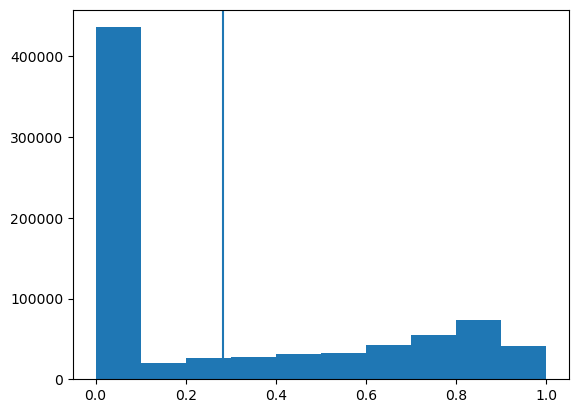

In [6]:
data = next(iter(train_dataloader))
plt.hist(data[0].flatten())
plt.axvline(data[0].mean())

In [7]:
training_data_set_normal = datasets.FashionMNIST(
    root='data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
        ,transforms.Normalize(mean, std)
    ])
)

test_data_set_normal = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

After normalization of the dataset, the mean is also close to 0, and the standard deviation is set to 1

In [8]:
train_dataloader = DataLoader(training_data_set_normal, batch_size=batch_size)
test_dataloader = DataLoader(test_data_set_normal, batch_size=batch_size)

for X,y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


we could learn that 
+ number of data used for training the model: 64
+ channel: 1
+ height: 28
+ width: 28

Now, let's make a model!

In [9]:
device = "cpu"

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


we need to optimize the model parameters via training

In [11]:
loss_fn = nn.CrossEntropyLoss() # we are solving classification problems
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # use basic stochastic gradient descent

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [14]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n")
    train(train_dataloader, model, loss_fn, optimizer)
    # test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1

loss: 2.284086  [   64/60000]
loss: 2.212807  [ 6464/60000]
loss: 2.120860  [12864/60000]
loss: 2.080155  [19264/60000]
loss: 1.938097  [25664/60000]
loss: 1.864579  [32064/60000]
loss: 1.751099  [38464/60000]
loss: 1.629717  [44864/60000]
loss: 1.583086  [51264/60000]
loss: 1.409731  [57664/60000]
Epoch 2

loss: 1.460557  [   64/60000]
loss: 1.422898  [ 6464/60000]
loss: 1.176668  [12864/60000]
loss: 1.306518  [19264/60000]
loss: 1.071939  [25664/60000]
loss: 1.121046  [32064/60000]
loss: 1.078897  [38464/60000]
loss: 1.031362  [44864/60000]
loss: 1.079095  [51264/60000]
loss: 0.983667  [57664/60000]
Epoch 3

loss: 0.977201  [   64/60000]
loss: 1.040050  [ 6464/60000]
loss: 0.786051  [12864/60000]
loss: 1.011622  [19264/60000]
loss: 0.839215  [25664/60000]
loss: 0.880766  [32064/60000]
loss: 0.878852  [38464/60000]
loss: 0.844518  [44864/60000]
loss: 0.899140  [51264/60000]
loss: 0.835185  [57664/60000]
Epoch 4

loss: 0.766321  [   64/60000]
loss: 0.871214  [ 6464/60000]
loss

By training the vanilla model from the [link](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html), we got $1.1$ of AVG loss

Now we need to save the model

In [15]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 64.0%, Avg loss: 1.356318 



However, data normalization is effect only if the testing set is also normalized

In [ ]:
torch.save(model.state_dict(), "model_data_normalization.pth")
print("Saved PyTorch Model State to model_data_normalization.pth")

Saved PyTorch Model State to model.pth
